In [1]:
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import scipy.sparse as sp
import os

import matplotlib.pyplot as plt

from ipywidgets import interact

from calibration.helpers.io import *
from calibration.helpers.camera_model import *
from calibration.helpers.linear_alg import *
from mitsuba import ScalarTransform4f as T

from ipywidgets import interact

# Paths

In [2]:
folder_dataset = '../datasets/'
folder_params = 'data'
dataset_name = 'banana_sorted32_theta_5_70_4_phi_0_360_4'
param_ds_name = 'unanno36_sorted256_theta_5_70_8_phi_0_360_16'
path_dataset = os.path.join(folder_dataset, dataset_name)
path_params = os.path.join(folder_params, 'npp_' + param_ds_name + '.npy')

# Functions

In [3]:
def to_world(dataset, arr_angles, params):
  """ Get to world matrix for a given set of angles """
  # Filtering can be optimized
  arr_mtx = []

  for angles_inp in arr_angles:
    for i, entry in enumerate(dataset):
      angles, wo_measured, vargeo, pg_cam_matrix, ch_ids, ch_corners = entry[0] # No image required
      theta_i, phi_i, theta_o, phi_o = angles

      if theta_o == angles_inp[0] and \
         phi_o == angles_inp[1] and \
         vargeo == angles_inp[2]:

        mtx = get_to_world(params, pg_cam_matrix)
        mtx[:3, 3] *= 0.001
        arr_mtx.append(mtx)

  return np.array(arr_mtx)

In [4]:
def tfm_plane(params):
  ij_to_sample = rot_scipy(params[:3])
  ij_to_sample[0:3, 3] = params[3:6] * 0.001
  return T(ij_to_sample) @ T.translate([.31/2, .18/2, 0])

# Reconstructing from Captures

In [5]:
dataset = read_dataset(path_dataset, 8, v=True)
params_cam = load_params(path_params, v=True)

Reading ../datasets/banana_sorted32_theta_5_70_4_phi_0_360_4: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


Loaded parameters from data/npp_unanno36_sorted256_theta_5_70_8_phi_0_360_16.npy
********************



In [6]:
thetas_uniq, phis_uniq, vars_uniq = get_dataset_angles(dataset)
print("Available angles")
print(thetas_uniq, phis_uniq, vars_uniq)

Available angles
[ 5 26 48 70] [  0  90 180 270] [0 1]


In [31]:
arr_angles = np.array([
  [5, 0, 0],
])

arr_to_worlds = to_world(dataset, arr_angles, params_cam)
mtx_plane = tfm_plane(params_cam)

# Optimization

In [32]:
def_sample_count = 128
def_res_x = 6576 // 2
def_res_y = 4384 // 2
path_tex_init = 'scenes/textures/init.png'

In [33]:
mi.set_variant("cuda_ad_rgb")

In [65]:
def make_sensors(arr_to_worlds, yfov, resx, resy, aspect=1.5, sample_count=128):
  sensors = []
  for i, mtx in enumerate(arr_to_worlds):
    sensor = mi.load_dict({
      'type': 'perspective',
      'fov_axis': 'x',
      'near_clip': 0.001,
      'far_clip': 1000,
      'fov': yfov * aspect,
      'to_world': T(mtx),
      'sampler': {
        'type': 'independent',
        'sample_count': sample_count,
      },
      'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'rfilter': {
          'type': 'tent',
        },
        'sample_border': True,
      }
    })
    sensors.append(sensor)

  return sensors

def make_scene(path_tex, arr_to_worlds, mtx_plane, params_cam, resx, resy, aspect=1.5, sample_count=128):
  sensors = make_sensors(arr_to_worlds, params_cam[6], 
                         resx, resy, aspect, sample_count)
  
  scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
      'type': 'direct_reparam',
      'max_depth': 12,
    },

    # BSDFS
    # 'charuco': {
    #     'type': 'twosided',
    #     'material': {
    #         'type': 'diffuse',
    #         'reflectance': {
    #             'type': 'bitmap',
    #             'filename': path_tex,
    #             'filter_type': 'bilinear',
    #         }
    #     },
    # },
    'banana': {
      'type': 'diffuse',
      'reflectance': {
          'type': 'rgb',
          'value': [0.38753274, 0.42333278, 0.31004632],
      }
    },
    'white': {
      'type': 'diffuse',
      'reflectance': {
          'type': 'rgb',
          'value': [1.0, 1.0, 1.0],
      }
    },
    'off-white': {
      'type': 'diffuse',
      'reflectance': {
          'type': 'rgb',
          'value': [0.43839052, 0.5418346 , 0.48062846],
      }
    },
    'black': {
      'type': 'diffuse',
      'reflectance': {
          'type': 'rgb',
          'value': [.1, .12, .1],
      }
    },

    # Light
    'light': {
      'type': 'constant',
      'radiance': {
        'type': 'rgb',
        'value': 1.0,
      }
    },

    # Shapes
    'tex_plane': {
      'type': 'obj',
      'filename': 'scenes/meshes/tex_plane.obj',
      'to_world': T(mtx_plane) @ T.rotate(axis=[0,1,0], angle=-90),
      'bsdf': {
        'type': 'ref',
        'id': 'off-white',
      },
    },

    'sample_holder': {
      'type': 'obj',
      'filename': 'scenes/meshes/holder.obj',
      'to_world': T.translate([0, 0, 0.004]) @ T(mtx_plane) @ T.rotate(axis=[1,0,0], angle=-90),
      'bsdf': {
        'type': 'ref',
        'id': 'black',
      },
    
    },

    'mesh-source': {
      'type': 'ply',
      'filename': 'scenes/meshes/ball.ply',
      'to_world': T.scale(0.025) @ T(mtx_plane) @ T.translate([0, 0, 0.8]),
      'bsdf': {
        'type': 'ref',
        'id': 'banana',
      },
    }        
  })

  return scene, sensors

In [66]:
scene_opt, sensors = make_scene(path_tex_init, arr_to_worlds, mtx_plane, params_cam, 
                            def_res_x, def_res_y,
                            aspect=1.5, sample_count=def_sample_count)

In [67]:
## Read Images
ref_imgs = []
ref_img_0 = mi.TensorXf(mi.Bitmap('./captures/banana/0_0_5_0_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
# ref_img_1 = mi.TensorXf(mi.Bitmap('./captures/banana/0_0_48_90_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
# ref_img_2 = mi.TensorXf(mi.Bitmap('./captures/banana/0_0_48_180_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
# ref_img_3 = mi.TensorXf(mi.Bitmap('./captures/banana/0_0_48_270_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))

ref_imgs.append(ref_img_0)
# ref_imgs.append(ref_img_1)
# ref_imgs.append(ref_img_2)
# ref_imgs.append(ref_img_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


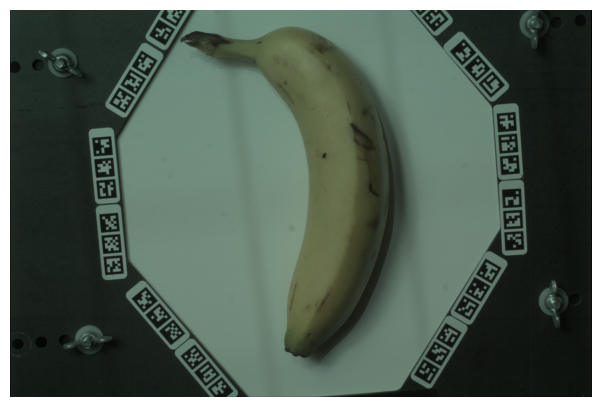

In [68]:
plt.figure(figsize=(7.5,7.5))
plt.axis('off')
plt.imshow(ref_imgs[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


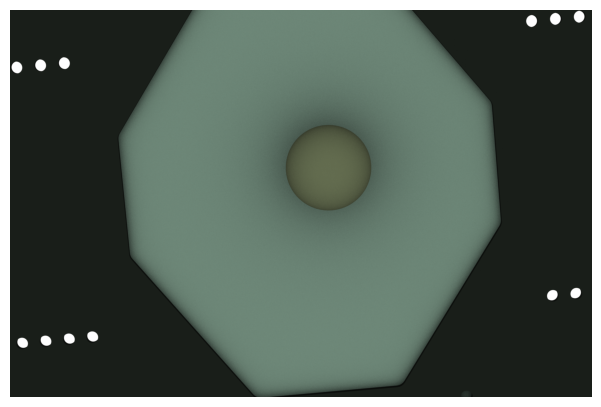

In [69]:
img_test = mi.render(scene_opt, sensor=sensors[0], spp=128)

plt.figure(figsize=(7.5,7.5))
plt.axis('off')
plt.imshow(img_test);

In [70]:
for i in range(len(sensors)):
  mi.util.write_bitmap(f'ref _image_{i}.png', ref_imgs[i], write_async=True)

In [71]:
for i in range(len(sensors)):
  img_opt = img_test = mi.render(scene_opt, sensor=sensors[i], spp=16)
  mi.util.write_bitmap(f'init _image_{i}.png', img_opt, write_async=True)

# Largesteps stuff

In [72]:
def compute_laplacian(n_verts, faces, lambda_):

    # Neighbor indices
    ii = faces[:, [1, 2, 0]].flatten()
    jj = faces[:, [2, 0, 1]].flatten()
    adj = np.unique(np.stack([np.concatenate([ii, jj]), np.concatenate([jj, ii])], axis=0), axis=1)
    adj_values = np.ones(adj.shape[1], dtype=np.float64) * lambda_

    # Diagonal indices, duplicated as many times as the connectivity of each index
    diag_idx = np.stack((adj[0], adj[0]), axis=0)

    diag = np.stack((np.arange(n_verts), np.arange(n_verts)), axis=0)

    # Build the sparse matrix
    idx = np.concatenate((adj, diag_idx, diag), axis=1)
    values = np.concatenate((-adj_values, adj_values, np.ones(n_verts)))

    return sp.csc_matrix((values, idx))

In [73]:
def to_differential(verts, faces, lambda_):
    L_csc = compute_laplacian(len(verts)//3, faces.numpy().reshape((-1,3)), lambda_)
    return mi.TensorXf((L_csc @ verts.numpy().reshape((-1,3))))

In [74]:
from cholespy import CholeskySolverF, MatrixType

class CholeskySolve(dr.CustomOp):

    def eval(self, solver, u):
        self.solver = solver
        x = dr.empty(dr.cuda.TensorXf, shape=u.shape)
        solver.solve(u, x)
        return mi.TensorXf(x)

    def forward(self):
        x = dr.empty(mi.TensorXf, shape=self.grad_in('u').shape)
        self.solver.solve(self.grad_in('u'), x)
        self.set_grad_out(x)

    def backward(self):
        x = dr.empty(dr.cuda.TensorXf, shape=self.grad_out().shape)
        self.solver.solve(self.grad_out(), x)
        self.set_grad_in('u', x)

    def name(self):
        return "Cholesky solve"

class CholeskySolver():
    def __init__(self, verts, faces, lambda_):
        n_verts = len(verts) // 3
        L_csc = compute_laplacian(n_verts, faces.numpy().reshape((-1,3)), lambda_)
        self.solver = CholeskySolverF(n_verts, mi.TensorXi(L_csc.indptr), mi.TensorXi(L_csc.indices), mi.TensorXd(L_csc.data), MatrixType.CSC)

    def solve(self, u):
        return dr.custom(CholeskySolve, self.solver, u)

In [75]:
n_viewpoints = 1

In [76]:
@interact(i=(0,n_viewpoints-1))
def show_target(i):
	plt.imshow((ref_imgs[i].numpy()).clip(0,1))
	plt.axis('off')

interactive(children=(IntSlider(value=0, description='i', max=0), Output()), _dom_classes=('widget-interact',)…

In [77]:
# mi.traverse(scene_opt)

In [78]:
params = mi.traverse(scene_opt)
lambda_ = 19

# param_tex = "banana.reflectance.value"

solver = CholeskySolver(params['mesh-source.vertex_positions'], params['mesh-source.faces'], lambda_)
opt = mi.ad.Adam(lr=1e-3, uniform=True, mask_updates=True)

# opt[param_tex] = params[param_tex]
opt['u'] = to_differential(params['mesh-source.vertex_positions'], params['mesh-source.faces'], lambda_)

In [87]:
num_steps = 150
tex_lrs = np.linspace(1e-5, 1e-1, num_steps)
loss_hist = np.zeros(num_steps)
from tqdm import trange
for it in trange(num_steps):
    loss = mi.Float(0.0)

    for i in range(n_viewpoints):
        params['mesh-source.vertex_positions'] = solver.solve(opt['u']).array
        params.update()
        
        img = mi.render(scene_opt, params, sensor=sensors[i], seed=it*n_viewpoints + i, spp=16)

        # L1 Loss
        img_loss = dr.mean(dr.abs(img - ref_imgs[i]))
        loss += img_loss

        loss_hist[it] += img_loss[0]

        dr.backward(img_loss)
        opt.step()
    
    print(f"Iteration {1+it:03d}/{num_steps}: Loss = {img_loss[0]:6f}", end='\r')

  1%|          | 1/150 [00:09<23:30,  9.47s/it]

  1%|▏         | 2/150 [00:19<23:49,  9.66s/it]

  2%|▏         | 3/150 [00:29<24:01,  9.80s/it]

  3%|▎         | 4/150 [00:39<24:05,  9.90s/it]

  3%|▎         | 5/150 [00:49<24:00,  9.93s/it]

  4%|▍         | 6/150 [00:58<23:20,  9.73s/it]

  5%|▍         | 7/150 [01:08<22:56,  9.63s/it]

  5%|▌         | 8/150 [01:17<22:31,  9.52s/it]

  6%|▌         | 9/150 [01:26<22:14,  9.47s/it]

  7%|▋         | 10/150 [01:36<22:09,  9.50s/it]

  7%|▋         | 11/150 [01:45<21:57,  9.48s/it]

  8%|▊         | 12/150 [01:55<21:53,  9.52s/it]

  9%|▊         | 13/150 [02:04<21:39,  9.49s/it]

  9%|▉         | 14/150 [02:14<21:24,  9.45s/it]

 10%|█         | 15/150 [02:23<21:16,  9.46s/it]

 11%|█         | 16/150 [02:32<21:05,  9.45s/it]

 11%|█▏        | 17/150 [02:42<20:51,  9.41s/it]

 12%|█▏        | 18/150 [02:51<20:39,  9.39s/it]

 13%|█▎        | 19/150 [03:00<20:29,  9.38s/it]

 13%|█▎        | 20/150 [03:10<20:18,  9.38s/it]

 14%|█▍        | 21/150 [03:19<20:10,  9.39s/it]

 15%|█▍        | 22/150 [03:29<20:04,  9.41s/it]

 15%|█▌        | 23/150 [03:38<19:56,  9.42s/it]

 16%|█▌        | 24/150 [03:48<19:45,  9.41s/it]

 17%|█▋        | 25/150 [03:57<19:35,  9.41s/it]

 17%|█▋        | 26/150 [04:06<19:26,  9.41s/it]

 18%|█▊        | 27/150 [04:16<19:29,  9.51s/it]

 19%|█▊        | 28/150 [04:25<19:12,  9.45s/it]

 19%|█▉        | 29/150 [04:35<18:58,  9.41s/it]

 20%|██        | 30/150 [04:44<18:41,  9.34s/it]

 21%|██        | 31/150 [04:53<18:32,  9.35s/it]

 21%|██▏       | 32/150 [05:03<18:24,  9.36s/it]

 22%|██▏       | 33/150 [05:12<18:14,  9.36s/it]

 23%|██▎       | 34/150 [05:21<18:04,  9.35s/it]

 23%|██▎       | 35/150 [05:31<17:55,  9.35s/it]

 24%|██▍       | 36/150 [05:40<17:43,  9.32s/it]

 25%|██▍       | 37/150 [05:49<17:24,  9.24s/it]

 25%|██▌       | 38/150 [05:58<17:08,  9.18s/it]

 26%|██▌       | 39/150 [06:07<17:00,  9.19s/it]

 27%|██▋       | 40/150 [06:17<16:56,  9.24s/it]

 27%|██▋       | 41/150 [06:26<16:50,  9.27s/it]

 28%|██▊       | 42/150 [06:35<16:33,  9.20s/it]

 29%|██▊       | 43/150 [06:44<16:12,  9.09s/it]

 29%|██▉       | 44/150 [06:53<15:56,  9.03s/it]

 30%|███       | 45/150 [07:02<15:45,  9.01s/it]

 31%|███       | 46/150 [07:11<15:35,  8.99s/it]

 31%|███▏      | 47/150 [07:20<15:23,  8.97s/it]

 32%|███▏      | 48/150 [07:29<15:22,  9.04s/it]

 33%|███▎      | 49/150 [07:38<15:22,  9.14s/it]

 33%|███▎      | 50/150 [07:47<15:20,  9.20s/it]

 34%|███▍      | 51/150 [07:57<15:18,  9.28s/it]

 35%|███▍      | 52/150 [08:06<15:14,  9.33s/it]

 35%|███▌      | 53/150 [08:16<15:13,  9.41s/it]

 36%|███▌      | 54/150 [08:25<15:03,  9.41s/it]

 37%|███▋      | 55/150 [08:35<14:52,  9.39s/it]

 37%|███▋      | 56/150 [08:44<14:42,  9.39s/it]

 38%|███▊      | 57/150 [08:53<14:32,  9.38s/it]

 39%|███▊      | 58/150 [09:03<14:21,  9.37s/it]

 39%|███▉      | 59/150 [09:12<14:11,  9.36s/it]

 40%|████      | 60/150 [09:21<13:57,  9.30s/it]

 41%|████      | 61/150 [09:30<13:38,  9.20s/it]

 41%|████▏     | 62/150 [09:39<13:19,  9.08s/it]

 42%|████▏     | 63/150 [09:48<13:15,  9.14s/it]

 43%|████▎     | 64/150 [09:58<13:09,  9.19s/it]

 43%|████▎     | 65/150 [10:06<12:41,  8.96s/it]

 44%|████▍     | 66/150 [10:15<12:42,  9.08s/it]

 45%|████▍     | 67/150 [10:24<12:32,  9.06s/it]

 45%|████▌     | 68/150 [10:34<12:30,  9.16s/it]

 46%|████▌     | 69/150 [10:43<12:26,  9.22s/it]

 47%|████▋     | 70/150 [10:52<12:02,  9.04s/it]

 47%|████▋     | 71/150 [11:01<11:57,  9.09s/it]

 48%|████▊     | 72/150 [11:10<11:48,  9.08s/it]

 49%|████▊     | 73/150 [11:19<11:35,  9.03s/it]

 49%|████▉     | 74/150 [11:28<11:34,  9.14s/it]

 50%|█████     | 75/150 [11:37<11:18,  9.05s/it]

 51%|█████     | 76/150 [11:47<11:16,  9.14s/it]

 51%|█████▏    | 77/150 [11:56<11:12,  9.21s/it]

 52%|█████▏    | 78/150 [12:06<11:18,  9.42s/it]

 53%|█████▎    | 79/150 [12:15<11:07,  9.41s/it]

 53%|█████▎    | 80/150 [12:24<10:49,  9.28s/it]

 54%|█████▍    | 81/150 [12:33<10:24,  9.04s/it]

 55%|█████▍    | 82/150 [12:41<10:04,  8.89s/it]

 55%|█████▌    | 83/150 [12:50<09:47,  8.78s/it]

 56%|█████▌    | 84/150 [12:58<09:35,  8.71s/it]

 57%|█████▋    | 85/150 [13:06<09:11,  8.48s/it]

 57%|█████▋    | 86/150 [13:14<08:53,  8.34s/it]

 58%|█████▊    | 87/150 [13:22<08:42,  8.29s/it]

 59%|█████▊    | 88/150 [13:31<08:33,  8.28s/it]

 59%|█████▉    | 89/150 [13:39<08:21,  8.23s/it]

 60%|██████    | 90/150 [13:48<08:22,  8.37s/it]

 61%|██████    | 91/150 [13:56<08:12,  8.35s/it]

 61%|██████▏   | 92/150 [14:04<08:01,  8.31s/it]

 62%|██████▏   | 93/150 [14:12<07:48,  8.22s/it]

 63%|██████▎   | 94/150 [14:20<07:40,  8.22s/it]

 63%|██████▎   | 95/150 [14:28<07:25,  8.11s/it]

 64%|██████▍   | 96/150 [14:36<07:13,  8.03s/it]

 65%|██████▍   | 97/150 [14:44<07:02,  7.98s/it]

 65%|██████▌   | 98/150 [14:52<06:53,  7.95s/it]

 66%|██████▌   | 99/150 [15:00<06:43,  7.92s/it]

 67%|██████▋   | 100/150 [15:07<06:34,  7.90s/it]

 67%|██████▋   | 101/150 [15:15<06:26,  7.88s/it]

 68%|██████▊   | 102/150 [15:23<06:17,  7.87s/it]

 69%|██████▊   | 103/150 [15:31<06:09,  7.87s/it]

 69%|██████▉   | 104/150 [15:39<06:01,  7.86s/it]

 70%|███████   | 105/150 [15:47<05:53,  7.86s/it]

 71%|███████   | 106/150 [15:56<06:01,  8.23s/it]

 71%|███████▏  | 107/150 [16:05<06:02,  8.42s/it]

 72%|███████▏  | 108/150 [16:14<06:05,  8.69s/it]

 73%|███████▎  | 109/150 [16:23<06:03,  8.87s/it]

 73%|███████▎  | 110/150 [16:33<06:01,  9.03s/it]

 74%|███████▍  | 111/150 [16:42<05:56,  9.13s/it]

 75%|███████▍  | 112/150 [16:51<05:49,  9.21s/it]

 75%|███████▌  | 113/150 [17:01<05:43,  9.27s/it]

 76%|███████▌  | 114/150 [17:10<05:34,  9.30s/it]

 77%|███████▋  | 115/150 [17:20<05:26,  9.33s/it]

 77%|███████▋  | 116/150 [17:29<05:19,  9.41s/it]

 78%|███████▊  | 117/150 [17:39<05:10,  9.42s/it]

 79%|███████▊  | 118/150 [17:48<04:57,  9.30s/it]

 79%|███████▉  | 119/150 [17:57<04:45,  9.22s/it]

 80%|████████  | 120/150 [18:06<04:34,  9.16s/it]

 81%|████████  | 121/150 [18:15<04:28,  9.26s/it]

 81%|████████▏ | 122/150 [18:24<04:19,  9.26s/it]

 82%|████████▏ | 123/150 [18:33<04:08,  9.20s/it]

 83%|████████▎ | 124/150 [18:43<03:58,  9.15s/it]

 83%|████████▎ | 125/150 [18:52<03:48,  9.12s/it]

 84%|████████▍ | 126/150 [19:01<03:38,  9.10s/it]

 85%|████████▍ | 127/150 [19:10<03:29,  9.11s/it]

 85%|████████▌ | 128/150 [19:19<03:22,  9.20s/it]

 86%|████████▌ | 129/150 [19:29<03:16,  9.34s/it]

 87%|████████▋ | 130/150 [19:38<03:05,  9.28s/it]

 87%|████████▋ | 131/150 [19:47<02:56,  9.27s/it]

 88%|████████▊ | 132/150 [19:57<02:47,  9.30s/it]

 89%|████████▊ | 133/150 [20:06<02:37,  9.29s/it]

 89%|████████▉ | 134/150 [20:15<02:28,  9.29s/it]

 90%|█████████ | 135/150 [20:24<02:19,  9.28s/it]

 91%|█████████ | 136/150 [20:34<02:09,  9.28s/it]

 91%|█████████▏| 137/150 [20:43<01:59,  9.22s/it]

 92%|█████████▏| 138/150 [20:52<01:50,  9.21s/it]

 93%|█████████▎| 139/150 [21:01<01:40,  9.16s/it]

 93%|█████████▎| 140/150 [21:10<01:31,  9.14s/it]

 94%|█████████▍| 141/150 [21:19<01:22,  9.12s/it]

 95%|█████████▍| 142/150 [21:28<01:12,  9.10s/it]

 95%|█████████▌| 143/150 [21:37<01:03,  9.09s/it]

 96%|█████████▌| 144/150 [21:46<00:54,  9.10s/it]

 97%|█████████▋| 145/150 [21:55<00:45,  9.09s/it]

 97%|█████████▋| 146/150 [22:05<00:36,  9.10s/it]

 98%|█████████▊| 147/150 [22:14<00:27,  9.15s/it]

 99%|█████████▊| 148/150 [22:23<00:18,  9.16s/it]

 99%|█████████▉| 149/150 [22:33<00:09,  9.28s/it]

100%|██████████| 150/150 [22:42<00:00,  9.08s/it]

In [88]:
params['mesh-source.vertex_positions'] = solver.solve(opt['u']).array
params.update()
final_imgs = []
for i in range(n_viewpoints):
	img_opt = mi.render(scene_opt, spp=64, sensor=sensors[i])
	final_imgs.append(img_opt)
	mi.util.write_bitmap(f'final_image_{i}.png', img_opt, write_async=True)

In [89]:
@interact(i=(0,n_viewpoints-1))
def show_final(i):
	plt.imshow((final_imgs[i].numpy()).clip(0,1))
	plt.axis('off')

interactive(children=(IntSlider(value=0, description='i', max=0), Output()), _dom_classes=('widget-interact',)…

In [86]:
@interact(i=(0,n_viewpoints-1))
def show_final(i):
	plt.imshow((ref_imgs[i].numpy()).clip(0,1))
	plt.axis('off')

interactive(children=(IntSlider(value=0, description='i', max=0), Output()), _dom_classes=('widget-interact',)…